In [313]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import math
import warnings
import scipy.stats as stats
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

from IPython.display import display
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set(style='whitegrid', palette='mako')

warnings.filterwarnings(
    action='ignore',
    module='scipy',
    message='^internal gelsd')

#function to call statsmodels model

def regstats (regr):
    print('Coefficients:\n{}\n'.format(lm.params))
    print('p-values:\n{}\n'.format(lm.pvalues))
    print('R-Squared:\n{}\n'.format(lm.rsquared))
    print('Confidence Interval:\n{}'.format(lm.conf_int()))
    prstd, iv_l, iv_u = wls_prediction_std(lm)
    plt.figure()
    plt.plot(iv_u[0:100], 'o', color='r')
    plt.plot(iv_l[0:100], 'o', color='r')
    plt.plot(lm.fittedvalues[0:100], 'o', color='b')
    plt.title('blue: predicted, red: 95% CI')
    plt.show()
    
    
#fucntion to clean FBI crime xls   
def cleandata (state):
    state.columns = map(str.lower, state.columns)
    state.columns = state.columns.str.split().str[0].str.strip()
    state.fillna(0, inplace=True)
    state.columns.values[5] = 'rape0'
    cols = state[['population', 'violent', 'robbery','rape0', 'aggravated', 'property', 'burglary', 'larceny-', 'arson3', 'motor']]
    for col in cols:    
        state[col] = state[col].astype(str)
        state[col] = state[col].str.replace(',','')
        state[col] = state[col].apply(pd.to_numeric)
    state.drop(columns='rape', inplace=True)
    
#function to return concerned indicators
def modelstats (lm):
    plt.figure()
    plt.hist(lm.resid)
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()
    plt.figure()
    plt.scatter(lm.predict(), lm.resid)
    plt.xlabel("Predicted")
    plt.ylabel("Residual")
    plt.axhline(y=0,color='red')
    plt.title('Predicted vs Residual')
    plt.show()
    regstats(lm)
    print("Residuals mean: {}".format(sum(lm.resid)/len(lm.resid)))
    
    
def addfeatures(state):
    state['popsq'] = state['population']**2
    means = state[['violent','aggravated','burglary']].mean(axis=0)
    stds = state[['violent','aggravated','burglary']].std(axis=0)
    state['V_A_B'] = ((state[['violent','aggravated','burglary']] - means)/ stds).mean(axis=1)
    state['arson3'] = np.where((state['arson3']>0), 1, 0)
    state['motor'] = np.where((state['motor']>0), 1, 0)
    state['robbery'] = np.where((state['robbery']>0), 1, 0)
    state['murder'] = np.where((state['murder']>0), 1, 0)
    state['larceny']=state['larceny-']
    state.drop(columns='larceny-', inplace=True)
    
    

# The original model

In [314]:
#Load data
nycrime = pd.read_csv('newyorkcrime.csv')
nycrime.dtypes

City                                       object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter      int64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2                object
Robbery                                    object
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                   object
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
dtype: object

In [315]:
#clean data (see u2l4p2/4)
cleandata(nycrime)
nycrime.dtypes

city           object
population      int64
violent         int64
murder          int64
rape0           int64
robbery         int64
aggravated      int64
property        int64
burglary        int64
larceny-        int64
motor           int64
arson3        float64
dtype: object

In [316]:
#drop new york
nycrime = nycrime.loc[nycrime['property']<5000]
nycrime.head()
addfeatures(nycrime)

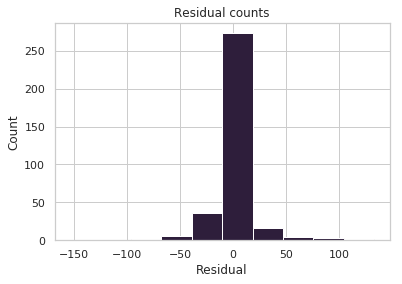

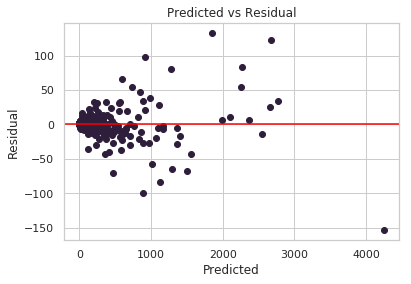

Coefficients:
Intercept     36.430
population     0.001
popsq         -0.000
murder        -3.898
robbery       -1.854
motor          1.204
arson3         5.945
V_A_B        100.839
larceny        1.078
dtype: float64

p-values:
Intercept    0.000
population   0.001
popsq        0.000
murder       0.376
robbery      0.535
motor        0.698
arson3       0.092
V_A_B        0.000
larceny      0.000
dtype: float64

R-Squared:
0.9981793017036144

Confidence Interval:
                 0       1
Intercept   31.379  41.481
population   0.000   0.001
popsq       -0.000  -0.000
murder     -12.547   4.751
robbery     -7.725   4.018
motor       -4.895   7.303
arson3      -0.977  12.867
V_A_B       96.081 105.597
larceny      1.063   1.092


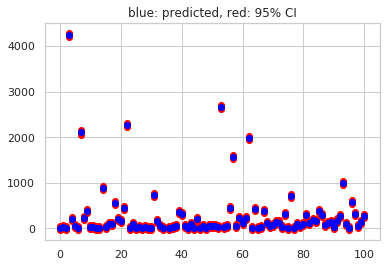

Residuals mean: 2.6720789715251307e-09


In [317]:
# Use 'new_model' with smf
lform = 'property ~ population+popsq+murder+robbery+motor+arson3+V_A_B+larceny'
lm = smf.ols(formula=lform, data=nycrime).fit()
modelstats(lm)



In [318]:
nycrime.head()

,city,population,violent,murder,rape0,robbery,aggravated,property,burglary,motor,arson3,popsq,V_A_B,larceny
0,Adams Village,1861,0,0,0,0,0,12,2,0,0,3463321,-0.377,10
1,Addison Town and Village,2577,3,0,0,0,3,24,3,1,0,6640929,-0.348,20
2,Akron Village,2846,3,0,0,0,3,16,1,0,0,8099716,-0.355,15
3,Albany,97956,791,1,30,1,526,4090,705,1,0,9595377936,7.423,3243
4,Albion Village,6388,23,0,3,1,16,223,53,1,0,40806544,-0.045,165


# Validating the model against other states

In [319]:
#load and prepare the data(new jersey and pennsylvania)
newjersey = pd.read_csv('newjersey.csv')
newjersey.rename(columns={'Arson':'Arson3'}, inplace=True)
cleandata(newjersey)
newjersey = newjersey.loc[newjersey['property']<5000]
addfeatures(newjersey)

penn = pd.read_csv('penn.csv')
cleandata(penn)
penn = penn.loc[penn['property']<5000]
addfeatures(penn)

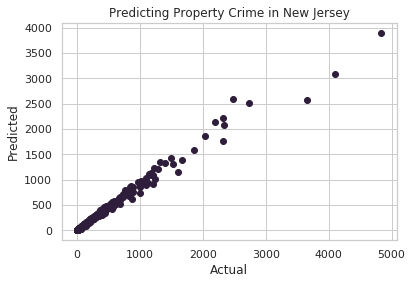

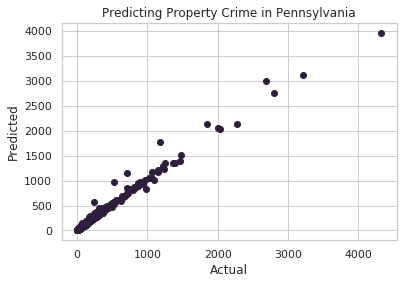

In [320]:
#quick visualizations
plt.scatter(newjersey.property, lm.predict(newjersey))
plt.title('Predicting Property Crime in New Jersey')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()

plt.scatter(penn.property, lm.predict(penn))
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Predicting Property Crime in Pennsylvania')
plt.show()

The reason why the R squared is high is because of the variable: Larceny-theft. Using this variable alone, the R-squared is 98.7%


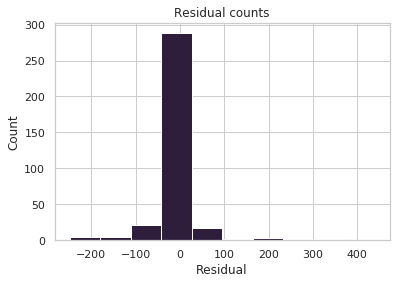

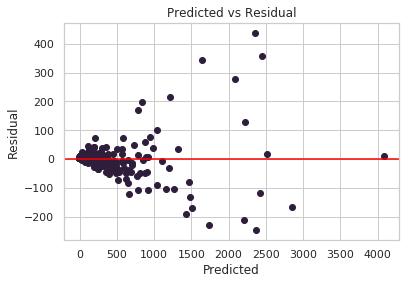

Coefficients:
Intercept   -4.781
larceny      1.260
dtype: float64

p-values:
Intercept   0.190
larceny     0.000
dtype: float64

R-Squared:
0.9874388200671762

Confidence Interval:
                0     1
Intercept -11.947 2.384
larceny     1.245 1.275


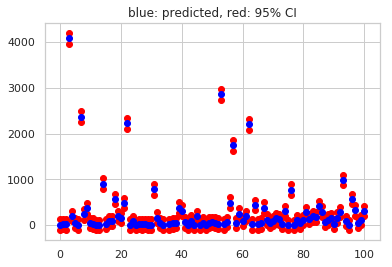

Residuals mean: -3.3213741834367476e-14


In [321]:
modlm = 'property ~ larceny'
lm = smf.ols(formula=modlm, data=nycrime).fit()
modelstats(lm)

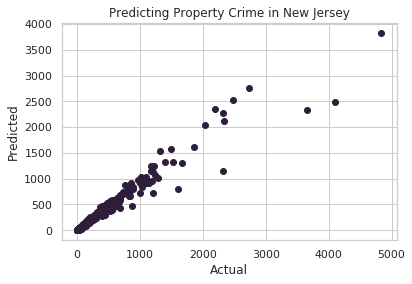

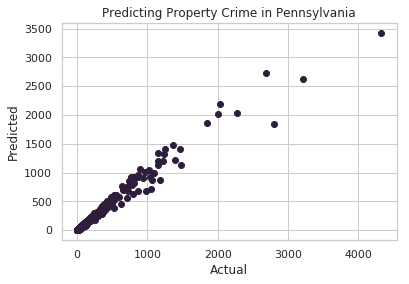

In [322]:
plt.scatter(newjersey.property, lm.predict(newjersey))
plt.title('Predicting Property Crime in New Jersey')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.show()

plt.scatter(penn.property, lm.predict(penn))
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Predicting Property Crime in Pennsylvania')
plt.show()

# Cross Validation

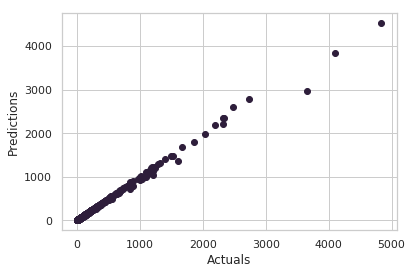

In [323]:
#train with your dataset and and validate (method from previous lession)
train = nycrime #training data
test = newjersey #new data
X = train.drop(columns=['city','property'])
y = train['property']

X1 = test.drop(columns=['city','property'])
y1 = test['property']

cvregr = linear_model.LinearRegression()
cvmodel = cvregr.fit(X, y)

predicted = cvregr.predict(X1)

plt.scatter(x=y1,y=predicted)
plt.xlabel('Actuals')
plt.ylabel('Predictions')
plt.show()



In [324]:
print('\nCoefficients: \n', cvregr.coef_)
print('\nIntercept: \n', cvregr.intercept_)
print('\nR-squared:')
print(cvregr.score(X, y))


Coefficients: 
 [ 1.28886717e-04  5.02293587e-01 -2.83719889e+00 -9.03073521e-01
 -1.04004007e+00 -5.24686901e-01  1.03534334e+00  1.90903303e+00
  1.79138734e+00  1.89073313e-10  2.28032999e-03  1.00580302e+00]

Intercept: 
 -0.9865233638890913

R-squared:
0.999878292813996


In [325]:
print(cvmodel.score(X1, y1))

0.9929537160803861


In [326]:
scoresny = cross_val_score(cvmodel, X, y, cv=5)
scoresnj = cross_val_score(cvmodel, X1, y1, cv=5)
print(scoresny)
print(scoresnj)
print('Accuracy: {}'.format(metrics.r2_score(y1,predicted)))

[0.99995446 0.99982187 0.99954626 0.9996488  0.9997517 ]
[0.99291504 0.98492336 0.98462993 0.99768528 0.99888657]
Accuracy: 0.9929537160803861


In [327]:
# Remove larceny for fun
nycrime.drop(columns='larceny',inplace=True)
newjersey.drop(columns='larceny',inplace=True)
penn.drop(columns='larceny',inplace=True)

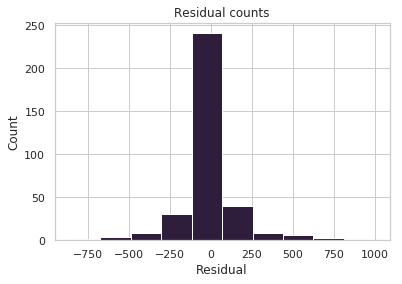

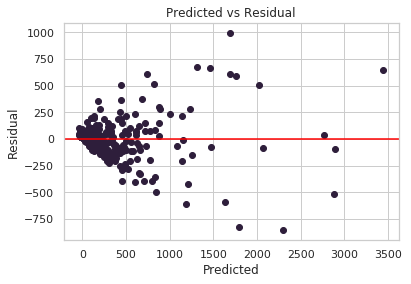

Coefficients:
Intercept     73.695
population     0.020
popsq         -0.000
murder       -61.734
robbery       27.936
motor        -18.643
arson3        20.519
V_A_B        314.586
dtype: float64

p-values:
Intercept    0.001
population   0.000
popsq        0.000
murder       0.088
robbery      0.255
motor        0.465
arson3       0.479
V_A_B        0.000
dtype: float64

R-Squared:
0.8761927333249424

Confidence Interval:
                  0       1
Intercept    32.302 115.088
population    0.018   0.023
popsq        -0.000  -0.000
murder     -132.674   9.207
robbery     -20.301  76.173
motor       -68.815  31.529
arson3      -36.455  77.493
V_A_B       282.950 346.222


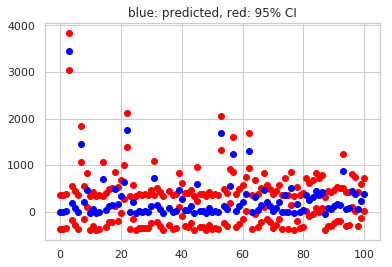

Residuals mean: 2.639319254105727e-10


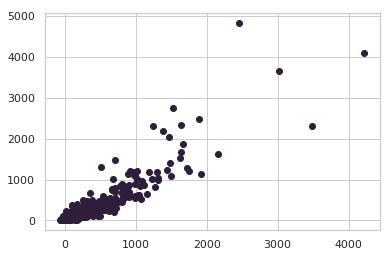

In [328]:
lform = 'property ~ population+popsq+murder+robbery+motor+arson3+V_A_B'
lm = smf.ols(formula=lform, data=nycrime).fit()
modelstats(lm)
plt.scatter(lm.predict(newjersey),y1)

We see that the p-values for :
1. murder       0.088
2. robbery      0.255
3. motor        0.465
4. arson3       0.479
          
      are all higher than .05, so they can be dropped without adversely affecting the r squared.

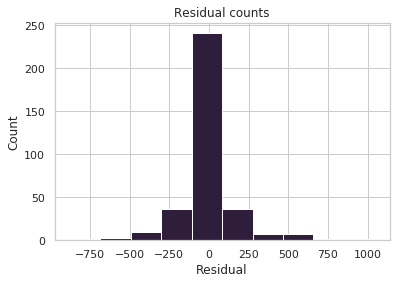

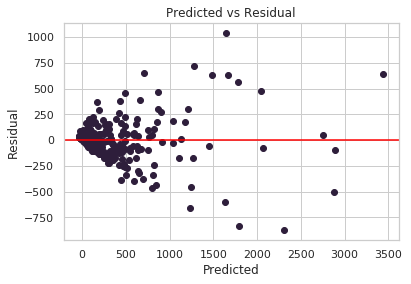

Coefficients:
Intercept     72.740
population     0.020
popsq         -0.000
V_A_B        307.185
dtype: float64

p-values:
Intercept    0.000
population   0.000
popsq        0.000
V_A_B        0.000
dtype: float64

R-Squared:
0.874476591814811

Confidence Interval:
                 0       1
Intercept   42.062 103.418
population   0.018   0.022
popsq       -0.000  -0.000
V_A_B      277.171 337.199


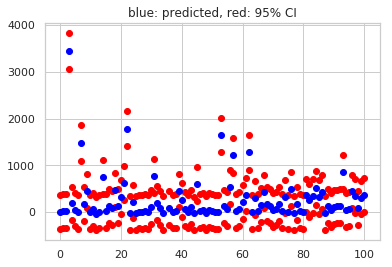

Residuals mean: 2.876810727621189e-09


In [329]:
#refit model
lform = 'property ~ population+popsq+V_A_B'
lm = smf.ols(formula=lform, data=nycrime).fit()
modelstats(lm)

### Cross validate refit model

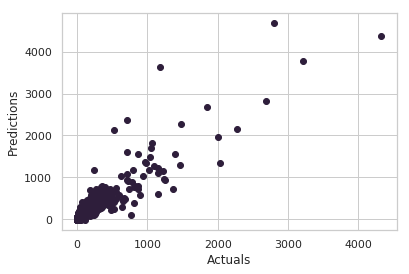

In [333]:
train = nycrime #training data
test = penn #new data
X = train[['population','popsq','V_A_B']]
y = train['property']

X1 = test[['population','popsq','V_A_B']]
y1 = test['property']

cvregr = linear_model.LinearRegression()
cvmodel = cvregr.fit(X, y)

predicted = cvregr.predict(X1)

plt.scatter(x=y1,y=predicted)
plt.xlabel('Actuals')
plt.ylabel('Predictions')
plt.show()


In [340]:
crossscore = cross_val_score(cvmodel,X,y,cv=10)
print(crossscore, crossscore.mean())

[0.9253037  0.80059921 0.70836716 0.73277269 0.86754141 0.5429383
 0.84383528 0.68018131 0.94472948 0.07690524] 0.7123173792970474


### Cross predictions

In [344]:
crosspre = cross_val_predict(cvmodel, X1, y1, cv=5)
print (metrics.r2_score(y1,crosspre))

0.8468791885447653
